## 📖 2023년 10월 7일 코드실습 (CNN)

## 📚 실습 목차

1. 이미지 데이터 시각화
1. Pytorch 를 이용한 Convolution Neural Networks 이해
3. MLP 를 이용한 이미지 분류
1. Convolution Neural Networks 구현 및 학습
2. Deep Convolution Neural Networks 구현 및 학습
3. Transfer Learning 의 이해
4. Transfer Learning 구현 및 학습

---

## 실습 데이터셋: Tire Dataset
- [Tire Texture Image Recognition](https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition)
    - 타이어의 이미지가 주어졌을 때, 해당 타이어가 정상인지, 이상이 있는 타이어인지 예측하는, binary classification 이자 anomaly detection task.
    - **Google Drive 에 `datasets` 폴더 만들고 그 안에 zip 파일 다운로드 하기**    
- 위 데이터를 numpy array 로 변환한 데이터 [다운로드1](https://drive.google.com/file/d/1ViEykQXq1dh-ZRaBZ20RwUZsYuBFjVyf/view?usp=share_link), [다운로드2](https://drive.google.com/file/d/1-4_NJvxJps9gS6yLpXCJvGH4OK-BBH6l/view?usp=share_link)
    - **이 파일들도 위와 동일하게 `datasets` 폴더에 다운로드**


In [28]:
# 경로찾기
import os
dir_path = os.getcwd()

print(dir_path)

/home/jjam/jupyter/kaist


In [29]:
import os, random, torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)
base_dir='/home/jjam/jupyter/kaist'

seed=2023-10-7
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

cpu


In [30]:
training_normal_files = os.listdir(os.path.join(base_dir, "Tire Textures/training_data/normal"))
training_cracked_files = os.listdir(os.path.join(base_dir, "Tire Textures/training_data/cracked"))
testing_normal_files = os.listdir(os.path.join(base_dir, "Tire Textures/testing_data/normal"))
testing_cracked_files = os.listdir(os.path.join(base_dir, "Tire Textures/testing_data/cracked"))

print(f"# Normal 학습 데이터: {len(training_normal_files)}")
print(f"# Cracked 학습 데이터: {len(training_cracked_files)}")
print(f"# Normal 테스트 데이터: {len(testing_normal_files)}")
print(f"# Cracked 테스트 데이터: {len(testing_cracked_files)}")

# Normal 학습 데이터: 376
# Cracked 학습 데이터: 327
# Normal 테스트 데이터: 115
# Cracked 테스트 데이터: 210


In [31]:
import pandas as pd

df_train = pd.DataFrame({
    'base_dir':["Tire Textures/training_data/normal"]*len(training_normal_files) + ["Tire Textures/training_data/cracked"]*len(training_cracked_files),
    'image_id':training_normal_files + training_cracked_files,
    'label':[0]*len(training_normal_files) +  [1]*len(training_cracked_files),
    'class_name':['normal']*len(training_normal_files) +  ['cracked']*len(training_cracked_files),
    })

df_test = pd.DataFrame({
    'base_dir':["Tire Textures/testing_data/normal"]*len(testing_normal_files) + ["Tire Textures/testing_data/cracked"]*len(testing_cracked_files),
    'image_id':testing_normal_files + testing_cracked_files,
    'label':[0]*len(testing_normal_files) +  [1]*len(testing_cracked_files),
    'class_name':['normal']*len(testing_normal_files) +  ['cracked']*len(testing_cracked_files),
    })

display(df_train, df_test)

,base_dir,image_id,label,class_name
0,Tire Textures/training_data/normal,Normal (347).jpg,0,normal
1,Tire Textures/training_data/normal,Normal (242).jpg,0,normal
2,Tire Textures/training_data/normal,NewNormal142.jpg,0,normal
3,Tire Textures/training_data/normal,Normal (304).jpg,0,normal
4,Tire Textures/training_data/normal,NewNormal37.jpg,0,normal
...,...,...,...,...
698,Tire Textures/training_data/cracked,Cracked-20.jpg,1,cracked
699,Tire Textures/training_data/cracked,Cracked-96.jpg,1,cracked
700,Tire Textures/training_data/cracked,Cracked-281.jpg,1,cracked
701,Tire Textures/training_data/cracked,NewCracked12.jpg,1,cracked


,base_dir,image_id,label,class_name
0,Tire Textures/testing_data/normal,IMG_4292.jpg,0,normal
1,Tire Textures/testing_data/normal,IMG_4384.jpg,0,normal
2,Tire Textures/testing_data/normal,Untitled-37.jpg,0,normal
3,Tire Textures/testing_data/normal,IMG_4359.jpg,0,normal
4,Tire Textures/testing_data/normal,Normal-403.jpg,0,normal
...,...,...,...,...
320,Tire Textures/testing_data/cracked,Cracked-21.jpg,1,cracked
321,Tire Textures/testing_data/cracked,Cracked-20.jpg,1,cracked
322,Tire Textures/testing_data/cracked,IMG_4499.jpg,1,cracked
323,Tire Textures/testing_data/cracked,IMG_4458.jpg,1,cracked


# 2. 탐색적 데이터 분석 (Exploratory Data Analysis)
- 학습 데이터 전체에서 정상 타이어와 이상 타이어의 비율을 시각화하여 다시 표현해봅니다.
    - 학습 데이터에 정상 타이어가 이상 타이어보다 조금 더 많음을 확인할 수 있습니다.

학습 데이터에 normal tire 가 cracked tire 보다 조금 더 많음.


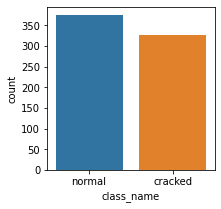

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(3,3))
sns.countplot(x="class_name", data=df_train)
print('학습 데이터에 normal tire 가 cracked tire 보다 조금 더 많음.')

- 이번에는 직접 이미지를 시각화하여 정상 타이어는 어떤 특징을, 이상 타이어는 어떤 특징을 가지는지 살펴봅시다.
- 아래 셀을 실행할 때마다, 랜덤으로 정상 타이어 3개, 이상 타이어 3개의 이미지를 보여줍니다.
- 사람의 육안으로 보았을 때, 확연히 구분되는 특징이 존재하는 것을 알 수 있습니다.

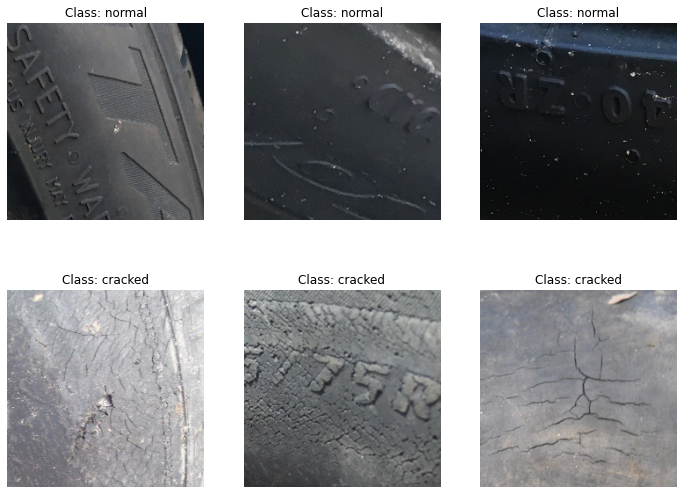

In [33]:
import cv2

def visualize_batch(df):
    plt.figure(figsize=(12, 9))

    for ind, (dir, image_id, label, class_name) in enumerate(df.values):
        plt.subplot(2, 3, ind + 1)
        image = cv2.imread(os.path.join(base_dir, dir , image_id))
        # print(image.shape)
        image = cv2.resize(image, (224, 224))
        # print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {class_name}", fontsize=12)
        plt.axis("off")

    plt.show()

normal_df = df_train.query('label==0').sample(3)
crack_df = df_train.query('label==1').sample(3)
tmp_df = pd.concat((normal_df, crack_df), axis=0)
visualize_batch(tmp_df)

# 3. 이미지 데이터 numpy 로 변환하기
- 폴더에 저장되어 있는 jpg 형태의 이미지 파일을 numpy array 로 변환합니다.
- 이렇게 numpy array 로 변환해야, pytorch tensor 로 변환하여 모델 학습이 가능하게 됩니다.
- 전체 이미지 사이즈는 (224, 224) 로 통일하여 resize 해줍니다.
- 처리 시간이 오래걸려서 처음에 다운로드 해놨던 전처리된 파일을 이용합니다.

In [36]:
from tqdm import tqdm
from joblib import dump, load
# helper function
def get_img(path):
    img = cv2.imread(path)
    return img

def resize_img(img, size):
    img = cv2.resize(img, size)
    return img

def img2array(df):
    image_array, image_label = [], []
    for dir_, image_id, label, class_name in tqdm(df.values):
        x = get_img(os.path.join(base_dir, dir_, image_id))
        x = resize_img(x, (224, 224))
        y = label
        image_array.append(x); image_label.append(y)
    return np.stack(image_array), np.stack(image_label)

# numpy array 로 변환
if os.path.isfile(os.path.join(base_dir, "train_data.pickle")):
    print('Loading Train data...')
    train_img, train_y = load(os.path.join(base_dir, "train_data.pickle"))
else:
    print('Processing and Saving Train data...')
    train_img, train_y = img2array(df_train)
    dump([train_img, train_y], os.path.join(base_dir, "train_data.pickle"))

if os.path.isfile(os.path.join(base_dir, "test_data.pickle")):
    print('Loading Test data...')
    test_img, test_y = load(os.path.join(base_dir, "test_data.pickle"))
else:
    print('Processing and Saving Test data...')
    test_img, test_y = img2array(df_test)
    dump([test_img, test_y], os.path.join(base_dir, "test_data.pickle"))

Loading Train data...
Loading Test data...


In [37]:
print(train_img.shape, train_y.shape)
print(test_img.shape, test_y.shape)

print('학습 이미지는 총 703개, 이미지의 크기는 (224, 224) 이미지의 채널 수는 3개 입니다 (rgb 3 channels).')
print('테스트 이미지는 총 325개, 이미지의 크기는 (224, 224) 이미지의 채널 수는 3개 입니다 (rgb 3 channels).')

(703, 224, 224, 3) (703,)
(325, 224, 224, 3) (325,)
학습 이미지는 총 703개, 이미지의 크기는 (224, 224) 이미지의 채널 수는 3개 입니다 (rgb 3 channels).
테스트 이미지는 총 325개, 이미지의 크기는 (224, 224) 이미지의 채널 수는 3개 입니다 (rgb 3 channels).


# 4. Convolution Layer 이해하기
<!-- <img src='./_img/CNN_1.PNG' width="600" height="200"> -->
<img src='https://www.codespeedy.com/wp-content/uploads/2019/05/convolutional-layers-of-an-image-Deep-learning-Machine-learning.jpg' width="600" height="auto">

- 위 그림에서 (36, 36, 3) 의 이미지가 Convolution layer 를 거친 후, (26, 26, 9) 의 feature map 으로 변환되는 것을 확인할 수 있습니다.
- 우리가 직접 CNN 을 구축해보기 위해서는, Convolution layer 를 거친 후, 이미지의 size 가 어떻게 변하게 될지 계산할 수 있어야 합니다.
- 먼저 pytorch convolution layer 를 통해 image 의 size 가 어떻게 변하는지 확인해보고, 직접 손으로 계산해보는 시간을 가져봅니다.
- `torch.nn.Conv2d()` 함수가 pytorch 에서 convolution 연산을 수행해주는 함수입니다.
    - [link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [38]:
import torch
import torch.nn as nn

# input 이미지의 크기: 100 x 100 (rgb 3 channels) 입니다.
# 1개의 이미지, 3개의 channel, (100,100) 크기의 이미지의 데이터셋을 임의로 생성해줍니다
input_image = torch.rand(1, 3, 100, 100)

# 그리고 다음과 같이 convolution layer 를 정의해줍니다.
conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=0)
# 각 인자들은 어떤 의미를 가질까요?

- `nn.Conv2d` 에 들어가는 각 인자 in_channels, out_channels, kernel_size, stride, padding 의 의미를 이해해 봅니다.
    - `in_channels` ($C_{in}$): 해당 layer 를 거치기 전 input feature map 의 channel 개수
    - `out_channels` ($C_{out}$): 해당 layer 를 거친 후 나온 output feature map 의 channel 개수
    - `kernel_size` ($f$): filter 의 size ($f$, $f$)
    - `stride` ($s$): stride 크기
    - `padding` ($p$): padding 크기

**Recap stride and padding**

<img src='https://miro.medium.com/max/640/1*YvlCSNzDEBGEWkZWNffPvw.gif' width=500 height=300>
<img src='https://miro.medium.com/max/640/1*34_365CJB5seboQDUrbI5A.gif' width=500 height=300>
<img src='https://miro.medium.com/max/640/1*gXAcHnbTxmPb8KjSryki-g.gif' width=500 height=300>
<img src='https://miro.medium.com/max/640/1*WpOcRWlofm0Z0EDUTKefzg.gif' width=500 height=300>

- 위와 같은 인자로 설정된 Convolution network 가 있을 때, 이번 layer 를 거쳐서 나온 output feature map 의 크기는 다음과 같이 계산 가능



$$
\lfloor \frac{n+2p-f}{s}+1 \rfloor
$$
    
- $n$ 은 input feature map 의 height or width
- $f$ 는 filter size
- $s$ 는 stride 크기
- $p$ 는 padding 크기

In [ ]:
c_in, c_out, n, f, s, p = 3, 5, 100, 3, 1, 0
input_image = torch.rand(1, 3, 100, 100)
conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=f, stride=s, padding=p)

output = conv1(input_image)
print('Conv 전 input 이미지 사이즈:', input_image.shape)
print('Conv 후 output 사이즈:', output.shape)


# (실습) 직접 output 의 size 를 계산해주는 함수를 만들어보세요.
def cal_next_img_size(c_out, n, f, s, p):
    return (c_out, int((n+2)))

print('직접 계산해본 Conv 후 output 사이즈:', cal_next_img_size(c_out, 100, f, s, p))

In [41]:
### (실습) 이번에는 Convolution layer 3개를 정의하고, 각 layer 를 거친 후의 output size 를 계산해봅니다. (5분)

In [ ]:
## 3개의 convolutional layer 를 정의하고, 각 layer 이후 나오는 output 의 크기를 구해봅니다.

input_image = torch.rand(3, 100, 100) # image size: 100 x 100 (rgb 3 channels)
print('Conv 전 input 이미지 사이즈:', input_image.shape)

### 이 부분을 채워주세요.
### convolution layer 3개를 정의해주세요.
### 그리고 각 layer 를 통과한 후의 output size 를 출력해주세요



###

### 그리고 직접 계산해본 output size 와 일치하는지 확인해보세요.

print('Conv 후 output 사이즈:', output.shape)

print('직접 계산해본 Conv 후 output 사이즈:', cal_next_img_size(5, 100, 3, 2, 0))
print('직접 계산해본 Conv 후 output 사이즈:', cal_next_img_size(10, 49, 3, 3, 0))
print('직접 계산해본 Conv 후 output 사이즈:', cal_next_img_size(20, 16, 5, 2, 0))

# 5. MLP 모델 구현하기 (실습)
지난 시간 MLP 때와 비슷하게 training data 와 test data 를 준비해줍니다

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TireDataset(Dataset):
    def __init__(self, img_array, y_array):
        self.img = img_array.transpose(0,3,1,2)
        self.label = y_array

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        return {'image':torch.FloatTensor(self.img[idx]), 'label':torch.Tensor([self.label[idx]])}

train_dataset = TireDataset(train_img, train_y)
test_dataset = TireDataset(test_img, test_y)

train_loader = DataLoader(train_dataset, batch_size=1024, drop_last=False, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, drop_last=False, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            ## 아래를 채워주세요 ##
            nn.Linear(224*224*3, 1024)
            nn.ReLU()
            nn.Linear(1024*512)
            nn.Relu()
            nn.Linear(512, 128)
            nn.ReLU()
            nn.Linear(128, 1)

            ####
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, 1, -1)
        ## 아래를 채워주세요 ##
        x = self.model(x)
        out = self.sigmoid(x)
        ####
        return out

model = MLP().to(device)

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate(loader):
    ys = [] ; preds = []
    for idx, data in enumerate(loader):
        x, y = data['image'], data['label']
        x = x.to(device).float()
        y = y.to(device).float()

        # forward pass
        out = model(x)

        ys.append(y.cpu().numpy()); preds.append(out.cpu().numpy())

    y = np.concatenate(ys)
    preds = np.concatenate(preds)
    auc = roc_auc_score(y, preds)

    return auc

In [ ]:
ptimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.BCELoss()

best, epochs=0, 30
train_accs = [] ; test_accs = []
for epoch in range(epochs):
    loss_all =0
    model.train()
    for idx, data in enumerate(train_loader):
        x, y = data['image'], data['label']

        x = x.to(device).float()
        y = y.to(device)

        # forward pass
        ## 아래를 채워주세요 ##
        out = model(x)
        loss = loss_fn(out, y.float())

        ####

        loss_all += loss.item()

        # backward pass
        ## 아래를 채워주세요 ##
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ####

    total_loss = loss_all/len(train_loader)
    total_loss = round(total_loss, 2)

    model.eval()
    with torch.set_grad_enabled(False):
        train_acc = evaluate(train_loader)
        test_acc = evaluate(test_loader)
        train_acc = round(train_acc.item(), 2)
        test_acc = round(test_acc.item(), 2)
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    st = f'|epoch : {epoch} | loss : {total_loss} | train_roc_auc = {train_acc} | test_roc_auc : {test_acc} |'
    print(st)

    # Save best model
    best_path = os.path.join(base_dir, 'CONV_best_model.pkl')

    if test_acc > best:
        best = test_acc
        torch.save(model.state_dict(), best_path)

### Testing
model.load_state_dict(torch.load(best_path))
model.eval()
with torch.set_grad_enabled(False):
    test_acc = evaluate(test_loader)
print('-'*40)
print('Test Accuracy:', test_acc)

In [ ]:
# Visulizae Accuracy Curve
epochs=range(epochs)

plt.figure(figsize=(5,3))
plt.style.use('seaborn')
plt.plot(epochs, train_accs, label='Training ROC AUC')
plt.plot(epochs, test_accs, label='Testing ROC AUC')
plt.ylabel('ROC AUC', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.title('ROC AUC Curve', fontsize=20)
plt.legend()
plt.show()

# 6. Simple CNN 모델 구현하기
- 다음과 같은 model 을 정의합니다.
    - input → Conv layer → non-linearity → Conv layer → non-linearity → Conv layer → non-linearity → flatten → hidden layer → nonlinearity → hidden layer → output
    - Convolution layer 를 다 거친 후, flatten 과정이 중요합니다. flatten 을 해주어야 linear transformation layer 를 거쳐 예측을 진행할 수 있습니다.
- 간단하게 3 layer CNN 과 그 사이에 non-linearity 를 추가한 모델을 정의합니다.

In [ ]:
class VerySimpleConv(nn.Module):
    def __init__(self):
        super(VerySimpleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=9, stride=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=5, out_channels=8, kernel_size=9, stride=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=9, stride=3, padding=0),
            nn.ReLU(),
        )
        self.linear = nn.Sequential(
            nn.Linear(16*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1, -1)
        x = self.linear(x)
        out = self.sigmoid(x)
        return out

model = VerySimpleConv().to(device)

# 7. Simple CNN 모델 학습하기
- 앞서 MLP 에서 학습한 방식과 동일하게 모델을 학습해볼 수 있습니다.

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate(loader):
    ys = [] ; preds = []
    for idx, data in enumerate(loader):
        x, y = data['image'], data['label']
        x = x.to(device).float()
        y = y.to(device).float()

        # forward pass
        out = model(x)

        ys.append(y.cpu().numpy()); preds.append(out.cpu().numpy())

    y = np.concatenate(ys)
    preds = np.concatenate(preds)
    auc = roc_auc_score(y, preds)

    return auc

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.BCELoss()

best, epochs=0, 30
train_accs = [] ; test_accs = []
for epoch in range(epochs):
    loss_all =0
    model.train()
    for idx, data in enumerate(train_loader):
        x, y = data['image'], data['label']

        x = x.to(device).float()
        y = y.to(device)

        # forward pass
        out = model(x)
        loss = loss_fn(out, y.float())

        ##

        loss_all += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss = loss_all/len(train_loader)
    total_loss = round(total_loss, 2)

    model.eval()
    with torch.set_grad_enabled(False):
        train_acc = evaluate(train_loader)
        test_acc = evaluate(test_loader)
        train_acc = round(train_acc.item(), 2)
        test_acc = round(test_acc.item(), 2)
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    st = f'|epoch : {epoch} | loss : {total_loss} | train_roc_auc = {train_acc} | test_roc_auc : {test_acc} |'
    print(st)

    # Save best model
    best_path = os.path.join(base_dir, 'CONV_best_model.pkl')

    if test_acc > best:
        best = test_acc
        torch.save(model.state_dict(), best_path)

### Testing
model.load_state_dict(torch.load(best_path))
model.eval()
with torch.set_grad_enabled(False):
    test_acc = evaluate(test_loader)
print('-'*40)
print('Test Accuracy:', test_acc)

In [ ]:
# Visulizae Accuracy Curve
epochs=range(epochs)

plt.figure(figsize=(5,3))
plt.style.use('seaborn')
plt.plot(epochs, train_accs, label='Training ROC AUC')
plt.plot(epochs, test_accs, label='Testing ROC AUC')
plt.ylabel('ROC AUC', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.title('ROC AUC Curve', fontsize=20)
plt.legend()
plt.show()

# 8. Pooling Layer 이해(실습)

**MaxPooling**

<img src="https://production-media.paperswithcode.com/methods/MaxpoolSample2.png" width=600 heigh='auto'>


- 다음과 같은 모델을 직접 구성해봅니다.
    - Conv Layer 를 `5개` 이상 생성
        - input → Conv layer → non-linearity → Conv layer → ... → Conv layer → non-linearity → flatten → hidden layer → non-linearity → hidden layer → output
    - 첫번째 conv layer 뒤에 Max Pooling layer 추가 `nn.MaxPool2d(kernel_size=2)`
        - [참고 link](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
        - input → Conv layer → non-linearity → `Max Pooling` → Conv layer → ... → Conv layer → non-linearity →  flatten → hidden layer → nonlinearity → hidden layer → output

    - Pooling 도 conv layer 처럼 stride, padding, filter size 등등 설정이 가능하지만, stride 와 padding 은 default 값으로 두고, fitler size 값을 조절하는 것이 일반적입니다.
    - 위 그림의 예시는 `nn.MaxPool2d(kernel_size=2)` 를 적용했을 때입니다.

In [ ]:
class DevelopConv(nn.Module):
    def __init__(self):
        super(DevelopConv, self).__init__()

        ### 다음과 같은 CNN + Pooling layer 조합의 모델이 있을 때,

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(????, 128), # nn.Linear 의 input_channel 에 들어갈 수로 알맞은 것을 적어보세요!
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        ###

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1, -1)
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

model = DevelopConv().to(device)

In [ ]:
# 여기서 에러가 난다면 계산을 잘못한 것입니다. 이 부분에서 에러가 나지 않도록 계산해보세요 !
model(torch.randn(1, 3, 224, 224).to(device))

# 9. Deep CNN with Batch normalization and dropout 구현 및 학습하기(실습) (10분)
- 다음과 같은 모델을 직접 구성해봅니다.
    - Conv Layer 를 3개 이상 생성
        - input → Conv layer → non-linearity → Conv layer → ... → Conv layer → non-linearity → flatten → hidden layer → non-linearity → hidden layer → output
    - 각 conv layer 뒤에 Batch Normalization layer 추가
        - [참고 link](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
        - input → Conv layer → batch normalization layer → non-linearity → Conv layer → batch normalization layer → ... → Conv layer → batch normalization layer → non-linearity → flatten → hidden layer → nonlinearity → hidden layer → output
    - fully connected layer 앞에 dropout 하기
        - input → Conv layer → batch normalization layer → non-linearity → Conv layer → batch normalization layer → ... → Conv layer → batch normalization layer → non-linearity → flatten → dropout layer → hidden layer → nonlinearity → dropout layer → hidden layer → output

In [ ]:
class DevelopConv(nn.Module):
    def __init__(self):
        super(DevelopConv, self).__init__()

        ### 이 부분을 채워주세요.
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels =5, kernel_size = 9, stride=3, padding=0),
        nn.BatchNorm2d(5),
        nn.ReLU(),
        nn.Conv2d(in_channels=5, out_channels=8, kernel_size = 9, stride =3, padding = 0),
        
        )

        ###

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        ### 이 부분을 채워주세요.

        ###
        return out

model = DevelopConv().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss()

best, epochs=0, 30
train_accs = [] ; test_accs = []
for epoch in range(epochs):
    loss_all =0
    model.train()
    for idx, data in enumerate(train_loader):
        x, y = data['image'], data['label']
        x = x.to(device).float()
        y = y.to(device)

        ### 이 부분을 채워주세요.


        ###

        loss_all += loss.item()

        ### 이 부분을 채워주세요.

        ###

    total_loss = loss_all/len(train_loader)
    total_loss = round(total_loss, 2)

    model.eval()
    with torch.set_grad_enabled(False):
        train_acc = evaluate(train_loader)
        test_acc = evaluate(test_loader)
        train_acc = round(train_acc.item(), 2)
        test_acc = round(test_acc.item(), 2)
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    st = f'| epoch : {epoch} | loss : {total_loss} | train_roc_auc = {train_acc} | test_roc_auc : {test_acc} |'
    print(st)

    # Save best model
    best_path = os.path.join(base_dir, 'DeepConv_best_model.pkl')

    if test_acc > best:
        best = test_acc
        torch.save(model.state_dict(), best_path)

### Testing
model.load_state_dict(torch.load(best_path))
model.eval()
with torch.set_grad_enabled(False):
    test_acc = evaluate(test_loader)
print('-'*40)
print('Test Accuracy:', test_acc)

# 10. Transfer Learning

<img src="https://miro.medium.com/v2/resize:fit:1400/1*9GTEzcO8KxxrfutmtsPs3Q.png" width=600 heigh='auto'>

- 전이학습 (Transfer Learning) 은 최근 몇년간 Machine Learning 및 Deep Learning 분야에서 매우 중요한 개념 중 하나입니다.
- 전이학습의 개념이 나오기 이전의 Traditional ML 은 한가지 task 를 수행하기 위해, 해당 task 에 대해 모델을 학습해야만 했습니다.
    - 예를 들어,
        - 개와 강아지를 분류하는 task 가 있다면, 이 task 에 대한 모델을 학습
        - 개와 토끼를 분류하는 task 가 있다면, 이 task 에 대한 모델을 학습
        - 폐질환을 분류하는 task 가 있다면, 이 task 에 대한 모델을 학습
        - 등등
- 하지만, labeled 데이터를 구하기 매우 어려운 task (privacy 의 이유로 또는 희귀병 같은) 의 경우에 적은 labeled 데이터로 모델 학습을 진행하면 좋은 성능을 내기가 어려웠습니다.

- 전이학습의 아이디어는 labeled data 를 구하기 쉬운 task 에서 모델을 학습하여 얻은 시각적 지식을 labeled data 를 구하기 어려운 task 에 전달 (transfer) 해주는 것입니다.
- 아래 예시를 보겠습니다.

<img src="https://www.mdpi.com/sensors/sensors-23-00570/article_deploy/html/images/sensors-23-00570-g001.png" width=600 heigh='auto'>

- 이미지 분류 태스크에서 주로 사용되는 데이터셋인 medical dataset 은 다양한 이유로 양질의 labeled dataset 을 구하기가 어렵습니다.
- 반면, ImageNet 데이터셋은 web 상에서 쉽게 구할 수 있어 매우 큰 dataset 을 구축할 수가 있습니다.
    - Imagenet 데이터셋은 굉장히 다양한 동물, 물체 등의 사진과 그에 대한 label 이 달려 있습니다.
- 여기에 전이학습의 아이디어를 적용하게 되면
    - CNN 모델을 ImageNet 데이터셋의 image 들을 잘 분류하게끔 학습을 진행해놓습니다.
    - 그러면 CNN 모델은 imagenet 내의 사진들의 시각적 특성을 아주 잘 파악할 수 있게 학습된 상태일 것입니다.
    - 예를 들어, 동물이나 물체를 잘 구분하기 위해서, 얼굴처럼 생긴 부분을 경계 또는 물체가 생긴 모양을 알 수 있는 경계 등을 잘 파악할 수 있도록 학습이 될 것입니다.

    - 이제 사전에 학습된 (pre-trained) CNN model 을 그대로 가져와서 medical 데이터셋에 알맞게 약간의 학습을 거치면 (fine-tuning), 처음부터 CNN 모델로 학습한 것보다 더 좋은 성능을 얻을 수 있습니다.
        - 왜냐하면, 이미 imagenet 을 기반으로 학습하면서, 시각적 특성을 잘 추출할 수 있는 능력은 충분히 지녔고, 이를 메디컬 도메인에서 중요한 부분만 추가적으로 파악할 수 있도록 모델이 학습되기 때문입니다.

- 이러한 Transfer Learning 은 비단 CNN model 에만 적용되는 것이 아닙니다. 요즘 매우 핫한 대형언어모델 (large language model) 도 전이학습의 방식을 채택하여, 미리 수집해놓은 대량의 데이터에 대형 모델을 사전학습한 모델입니다.


<img src="https://miro.medium.com/max/1400/1*mcFVMCbeIkCw23yooN-9qw.webp" width=600 heigh='auto'>

- 따라서 지난 몇년 간, 상당히 많은 Deep CNN architecture 들과 pretrained model 들이 공개되었습니다. 이 모델들은 다양한 이미지 태스크에서 매우 높은 성능을 보이는 것으로 잘 알려져 있습니다.
    - e.g., AlexNet, VGGNet, GoogLeNet, ResNet, 등등
- 이러한 모델들은 굉장히 Deep 한 CNN model 입니다. 앞서 Deep CNN 을 직접 구현해보셔서 느끼셨겠지만, 직접 Deep CNN 을 구현하여 사용하는 것은 꽤나 번거롭습니다.
- 예를 들어, 아래의 34 layer 짜리 ResNet 을 직접 구현한다고 생각하면 상당히 번거롭고, 쉽지가 않을 것입니다.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200424011138/ResNet.PNG" width=900 heigh='auto'>

- 또한 이렇게나 큰 CNN model 을 엄청나게 많은 양의 데이터셋에서 학습한다는 것도 일반적으로 쉽지 않은 일입니다.

- 그래서 다양한 패키지에서 많은 CNN 모델들을 pytorch 로 구현한 architecture 와 pretrained weights 까지 함께 제공하고 있습니다.
- 오늘은 그 중  `timm` 패키지와 `torchvision` 패키지로 공개된 Deep CNN 의 architecture 들을 사용해봅니다.

<!-- - `timm.create_model('vgg11', pretrained=False)`
    - pretrained=True 로 하면 사전학습된 weight 까지 불러오고
    - pretrained=False 로 하면 모델만 불러오게 됩니다. -->

## torchvision package 사용해보기
- `torchvision` 에서는 매우 다양한 architecture 들을 지원하고 있는데요.
- 그 중에서 오늘 저희는 미리 다운 받아온 vgg11 과 resnet18 을 사용해볼 것입니다.

In [42]:
import torchvision
import torch.nn as nn
dir(torchvision.models)

## 이렇게 하면 torchvision 에서 지원하는 다양한 architecture 들이 나오게 됩니다. 오늘 저희는 여기서 vgg11, resnet18 을 사용할 것입니다.

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [44]:
# 찾고자 하는 vgg와 resnet을 찾는다.
print([a for a in dir(torchvision.models) if 'vgg' in a])
print([a for a in dir(torchvision.models) if 'resnet' in a])

['vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
['resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'wide_resnet101_2', 'wide_resnet50_2']


In [45]:
# 이렇게 하면 pretrained weight 를 안쓰고, 그냥 architecture 만 불러옵니다.
# 이렇게 architecture 만 불러와서 처음부터 weight 를 다 학습하려는 목적이면 우리는 이걸 training from scratch 라고 부릅니다
resnet = torchvision.models.resnet18(pretrained=False)
vgg = torchvision.models.vgg11(pretrained=False)

/home/jjam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jjam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [46]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
# 하지만 우리는 전이학습을 하고 싶으니까, 사전학습된 weight 를 불러와 봅시다.
# 이렇게 하면 미리 다운받아놓은 걸로 쓸 수 있습니다.
resnet_weight = torchvision.models.resnet18(pretrained=False) 
# pretrained = False는 다운을 따로 받아야하고, pretrained = True를 하면 알아서 다운로드를 해준다.
weights = torch.load('/home/jjam/jupyter/kaist/resnet18-f37072fd.pth')
resnet_weight.load_state_dict(weights)

vgg_weight = torchvision.models.vgg11(pretrained=False)
weights = torch.load('/home/jjam/jupyter/kaist/vgg11-8a719046.pth')
vgg_weight.load_state_dict(weights)

<All keys matched successfully>

In [53]:
# 요게 그냥 architecture 만 불러온 모델의 weight → random initialize 되어 있습니다
print(resnet.layer1[0].conv1.weight[0][0])

# 요게 사전학습된 weight
print(resnet_weight.layer1[0].conv1.weight[0][0])
# 보면 weight 값이 확연히 다른 것을 확인할 수 있습니다

tensor([[-0.0401,  0.0440, -0.0654],
        [-0.1091,  0.0795,  0.0380],
        [-0.0321, -0.0389,  0.0191]], grad_fn=<SelectBackward0>)
tensor([[ 0.0576, -0.0951, -0.0203],
        [-0.0746, -0.7993, -0.2128],
        [ 0.0656, -0.0965, -0.0121]], grad_fn=<SelectBackward0>)


In [54]:
# 요게 그냥 architecture 만 불러온 모델의 weight → random initialize 되어 있습니다
print(vgg.features[0].weight[0][0])

# 요게 사전학습된 weight
print(vgg_weight.features[0].weight[0][0])
# 보면 weight 값이 확연히 다른 것을 확인할 수 있습니다

tensor([[ 0.0962, -0.0725, -0.1240],
        [-0.1538, -0.0777, -0.0475],
        [-0.0399, -0.0199, -0.0757]], grad_fn=<SelectBackward0>)
tensor([[ 0.2882,  0.0358, -0.3850],
        [ 0.1795,  0.3668, -0.5012],
        [-0.0974,  0.3648, -0.2296]], grad_fn=<SelectBackward0>)


In [ ]:
# 직접 파일을 미리 다운 받지 않고 그냥 이렇게 하면 그냥 패키지에서 자동으로 바로 다운받을 수 있습니다
resnet_weight2 = torchvision.models.resnet18(pretrained=True)

print('resnet')
print(resnet_weight2.layer1[0].conv1.weight[0][0])
print(resnet_weight.layer1[0].conv1.weight[0][0])

print('vgg')
vgg_weight2 = torchvision.models.vgg11(pretrained=True)
print(vgg_weight2.features[0].weight[0][0])
print(vgg_weight.features[0].weight[0][0])

# 미리 다운 받아 놓은 값과 동일하다는 것을 알 수 있습니다.

In [56]:
encoder = torchvision.models.resnet18(pretrained=False)

# torchvision 패키지에서 불러온 resnet18 model 이 어떻게 작동하는지 확인해보겠습니다.

input_image = torch.rand(1, 3, 100, 100) # image size: 100 x 100 (rgb 3 channels)

output = encoder(input_image)

print('Model 전 input 이미지 사이즈:', input_image.shape)
print('Model 후 output 사이즈:', output.shape)

Model 전 input 이미지 사이즈: torch.Size([1, 3, 100, 100])
Model 후 output 사이즈: torch.Size([1, 1000])


- 지금까지 해왔던 nn.Conv2d 함수와 작동하는 방식이 똑같음을 알 수 있습니다.
- 왜냐하면 `torchvision` 패키지에서 pytorch Conv2d 를 이용하여 구현을 해놓았기 때문입니다. 따라서 기존에 사용하던 방식과 동일하게 사용하실 수가 있습니다
- 또한, model 을 거치고 나오면 1000 dimension 의 flatten representation 을 얻게 됩니다.
- 그러므로, 아래와 같이 정말 편하게 `resnet18` 뿐만 아니라 다른 다양한 모델들을 활용할 수 있습니다.

In [57]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv = torchvision.models.resnet18(pretrained=False)

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        out = self.sigmoid(x)

        return out

resnet = ResNet().to(device)

In [58]:
input_image = torch.rand(1, 3, 100, 100) # image size: 100 x 100 (rgb 3 channels)
resnet(input_image.to(device))

tensor([[0.4473]], grad_fn=<SigmoidBackward0>)

## Pytorch Image Model Package 쓰기


In [59]:
try:
    import timm
except:
    !pip install timm
    import timm

In [61]:
# 굉장히 많은 CNN 모델들을 지원하고 있습니다.
print('지원하는 모델들 5개 예시: ', timm.list_models()[:5])
print('지원하는 총 모델 종류 개수: ', len(timm.list_models()))

# 유명한 모델인 VGGNet 관련해서 어떤 모델들이 지원되고 있는지 확인해보겠습니다
print('VGG 모델 종류:', [a for a in timm.list_models() if 'vgg' in a])

지원하는 모델들 5개 예시:  ['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384']
지원하는 총 모델 종류 개수:  991
VGG 모델 종류: ['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


간단히 예시로 `vgg11_bn` 모델을 사용해보겠습니다.

In [62]:
encoder = timm.create_model('vgg11_bn', pretrained=False)

In [63]:
encoder

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [64]:
# timm 패키지에서 불러온 vgg11_bn model 이 어떻게 작동하는지 확인해보겠습니다.

input_image = torch.rand(1, 3, 100, 100) # image size: 100 x 100 (rgb 3 channels)

output = encoder(input_image)

print('Model 전 input 이미지 사이즈:', input_image.shape)
print('Model 후 output 사이즈:', output.shape)

Model 전 input 이미지 사이즈: torch.Size([1, 3, 100, 100])
Model 후 output 사이즈: torch.Size([1, 1000])


- 지금까지 해왔던 nn.Conv2d 함수와 작동하는 방식이 똑같음을 알 수 있습니다.
- 왜냐하면 `timm` 패키지에서 pytorch Conv2d 를 이용하여 구현을 해놓았기 때문입니다. 따라서 기존에 사용하던 방식과 동일하게 사용하실 수가 있습니다
- 또한, model 을 거치고 나오면 1000 dimension 의 flatten representation 을 얻게 됩니다.
- 그러므로, 아래와 같이 정말 편하게 `vgg11_bn` 뿐만 아니라 다른 다양한 모델들을 활용할 수 있습니다.

In [65]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.conv = timm.create_model('vgg11_bn', pretrained=False)

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        out = self.sigmoid(x)

        return out

model = VGGNet().to(device)

In [66]:
model

VGGNet(
  (conv): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## Transfer Learning 진행해보기 (실습)

In [83]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        ### 아래를 채워보세요 ###
        self.conv = torchvision.models.resnet18(pretrained=False)
        self.conv.load_state_dict(torch.load("/home/jjam/jupyter/kaist/resnet18-f37072fd.pth"))
        #self.conv = torchvision.models.resnet(pretrained=True)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        ######

    def forward(self, x):
        ### 아래를 채워보세요 ###
        x = self.conv(x)
        x = self.fc(x)
        ######
        return x

model = ResNet().to(device)

In [84]:
from torch.utils.data import Dataset, DataLoader

class TireDataset(Dataset):
    def __init__(self, img_array, y_array):
        self.img = img_array.transpose(0,3,1,2)
        self.label = y_array

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        return {'image':torch.FloatTensor(self.img[idx]), 'label':torch.Tensor([self.label[idx]])}

train_dataset = TireDataset(train_img, train_y)
test_dataset = TireDataset(test_img, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, drop_last=False, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, drop_last=False, shuffle=False)

In [85]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss()

best, epochs=0, 30
train_accs = [] ; test_accs = []
for epoch in range(epochs):
    loss_all =0
    model.train()
    for idx, data in enumerate(train_loader):
        x, y = data['image'], data['label']
        x = x.to(device).float()
        y = y.to(device)

        ### 아래를 채워보세요 ###
        out = model(x)
        loss = loss_fn(out, y.float())
        ######
        
        loss_all += loss.item()

        ### 아래를 채워보세요 ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ######

    total_loss = loss_all/len(train_loader)
    total_loss = round(total_loss, 2)

    model.eval()
    with torch.set_grad_enabled(False):
        train_acc = evaluate(train_loader)
        test_acc = evaluate(test_loader)
        train_acc = round(train_acc.item(), 2)
        test_acc = round(test_acc.item(), 2)
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    st = f'|epoch : {epoch} | loss : {total_loss} | train_roc_auc = {train_acc} | test_roc_auc : {test_acc} |'
    print(st)

    # Save best model
    best_path = os.path.join(base_dir, 'transfer_best_model.pkl')

    if test_acc > best:
        best = test_acc
        torch.save(model.state_dict(), best_path)

### Testing
model.load_state_dict(torch.load(best_path))
model.eval()
with torch.set_grad_enabled(False):
    test_acc = evaluate(test_loader)
print('-'*40)
print('Test Accuracy:', test_acc)

NameError: name 'evaluate' is not defined